# Pairwise Binary classification with Deep Learning

In this notebook we will train Multilayer Perceptron Neural Network to detect whether two images are from same class (car brand) or not. To train Perceptron, we will use image embeddings got from trained CNN model (SOTA models such as MobileNet).

# Set up

## Packages and requirements

In [1]:
# Major builtin libraries
import os
import gc
import time
import random
import typing as t
from copy import deepcopy
from collections import defaultdict

In [3]:
import warnings  # If you want to disable warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

In [5]:
# Basic PyTorch
import torch
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms and dynamic learning rate adjusting
import torch.nn.functional as F
# from torch.nn.modules.loss import _Loss  # For writing a custom Loss function
from torch.utils.data import DataLoader, Dataset  # For custom data presentation

In [6]:
# Utils
import joblib  # Pipelining, pickling (dump/load), parallel processing
from tqdm import tqdm  # Progress bar for training process
from tempfile import TemporaryDirectory

# Classic ML tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold  # Cross-Validation

In [8]:
# ML Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchmetrics.classification import MulticlassF1Score, F1Score # F1 metric for multiclass

In [9]:
# Torch Computer Vision tools for images processing
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
from torchvision import models  # Pretrained models

In [10]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

In [11]:
# Output text colorizing
from colorama import Back, Style

def print_highlighted(text: str, bgcolor=Back.YELLOW) -> None:
    """
    Function to print a text with colored background.
    """
    print(bgcolor + text + Style.RESET_ALL)

In [12]:
import wandb # MLOps platform to simplify and speed up the process of building ML models

In [13]:
wandb.login() # We log in via pop-up,
# wandb.login(key=api_key)  # but you can also log in manually with function args

wandb: Currently logged in as: remainedmind. Use `wandb login --relogin` to force relogin


True

## Configuration

In [14]:
CONFIG = {
    "seed": 2306,
    # "epochs": 20,
    "image_dimension": 256,  # Depends on pretrained model used
    "model_name": "SiamesePerceptron",  # Pretrained model we will use
    "embedding_size": 512,  # Embedding output size
    "train_batch_size": 200,
    "val_batch_size": 400,
    "learning_rate": 1e-3,
    "min_lr": 1e-8,
    "min_loss_delta": 1e-7, # To stop training on plateau
    "weight_decay": 1e-7,

}

In [15]:
wandb_run = wandb.init(project="binary-classification-project", config=CONFIG)

In [16]:
config = wandb.config
del CONFIG

Set Seed for Reproducibility

In [17]:
def set_seed(seed=42):
    """
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False  # When False, this option makes CUDA reproducible, BUT the performance might suffer

    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed=config.seed)

# Data

For our MLP we will use image embeddings - output from CNN models. We already got this data before, so we just load it.

## Set data location

In [20]:
# config.repo = 'car-brands/'  # dataset name on Kaggle
config.repo = 'data/'  # dataset name on local device
# config.repo = 'car_brand_detection/'  # Google Collab

# config.root = '/kaggle/input/' + config.repo
# config.root = 'drive/MyDrive/' + config.repo
config.root = '../'  + config.repo

config.data_path = config.root + 'embeddings_and_labels.csv'

config.mlp_model_path = 'saved_instances/SiamesePerceptron.pth'
config.save_model_to = f'{config.model_name}.pth'

In [21]:
df = pd.read_csv(config.data_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.001561,0.159091,-0.326709,-0.226603,-0.097365,0.204614,-0.142634,0.208764,0.469837,0.069866,...,0.410457,-0.024682,0.178265,-0.357340,-0.073279,0.190458,-0.060786,0.364546,0.824516,Acura_MDX
1,0.229466,-0.186505,-0.329016,-0.650666,0.115301,0.149208,0.065496,0.191487,0.428920,-0.016147,...,0.195697,0.171068,0.037157,0.049534,-0.224402,0.225593,0.180314,0.073213,0.500426,Acura_MDX
2,-0.203165,0.330612,-0.413488,-0.128357,0.013811,0.244605,-0.137738,0.365148,0.385303,0.318809,...,0.413026,0.040102,0.054195,-0.251548,-0.020557,0.241178,0.062900,0.354683,0.591870,Acura_MDX
3,-0.052456,0.385235,-0.423291,-0.007358,0.031012,0.242327,0.118072,0.235620,0.464901,0.320997,...,0.412529,0.015200,0.237078,-0.429586,-0.110773,0.166453,0.079581,0.243743,0.662615,Acura_MDX
4,0.092909,0.075529,-0.040490,0.137453,0.531280,0.219033,-0.100117,0.161784,-0.077920,-0.265161,...,-0.024520,0.143381,-0.099898,0.137324,0.137523,0.217806,0.313156,0.400654,0.217053,Acura_MDX


In [22]:
df.columns[-20:]

Index(['493', '494', '495', '496', '497', '498', '499', '500', '501', '502',
       '503', '504', '505', '506', '507', '508', '509', '510', '511', 'label'],
      dtype='object')

**label** is our last column. Rest are embeddings

In [23]:
embeddings_bag = df[(df.columns[:-1])]
embeddings_bag.head(2)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.001561,0.159091,-0.326709,-0.226603,-0.097365,0.204614,-0.142634,0.208764,0.469837,0.069866,...,0.111356,0.410457,-0.024682,0.178265,-0.357340,-0.073279,0.190458,-0.060786,0.364546,0.824516
1,0.229466,-0.186505,-0.329016,-0.650666,0.115301,0.149208,0.065496,0.191487,0.428920,-0.016147,...,0.135340,0.195697,0.171068,0.037157,0.049534,-0.224402,0.225593,0.180314,0.073213,0.500426


In [24]:
labels = df[df.columns[-1]]
labels.head(2)

0    Acura_MDX
1    Acura_MDX
Name: label, dtype: object

In [25]:
labels.unique()[:10]

array(['Acura_MDX', 'Alfa Romeo_Giulietta', 'Audi_100', 'Audi_80',
       'Audi_A1', 'Audi_A3', 'Audi_A4', 'Audi_A5', 'Audi_A6', 'Audi_A7'],
      dtype=object)

In [26]:
config.num_of_classes = labels.nunique()

Now we apply One Hot Encoding

In [27]:
def apply_label_encoding(labels: t.Union[pd.Series, np.array],
                         encoder_name: os.path,
                         action='encode',
     ):
    """
    One Hot encoding. We apply encoding by replacing the label column in dataframe.
    As for decoding data back, we work with vector-array (as it's most likely to
    be a prediction result)
    """
    encoder = LabelEncoder()
    if action == 'encode':
        # We transform dataframe here. Nothing returns
        # data = data.with_columns(pl.DataFrame(encoder.fit_transform(data[column]), schema=['label']))
        labels = encoder.fit_transform(labels)

        with open(f"{encoder_name}_LEncoder.pkl", "wb") as fp:
                joblib.dump(encoder, fp)
        return labels
    elif action == 'decode':
        # We pass vector here. Result is a vector
        with open(f"{encoder_name}_LEncoder.pkl", "rb") as fp:
            encoder: LabelEncoder = joblib.load(fp)
        return encoder.inverse_transform(labels)

In [28]:
labels = pd.DataFrame(apply_label_encoding(labels, action='encode', encoder_name="embeddings_labels"), columns=['label'])
labels.head()

,label
0,0
1,0
2,0
3,0
4,0


In [29]:
apply_label_encoding(labels, action='decode', encoder_name="embeddings_labels")

array(['Acura_MDX', 'Acura_MDX', 'Acura_MDX', ..., 'ZIL_5301_Bychok',
       'ZIL_5301_Bychok', 'ZIL_5301_Bychok'], dtype=object)

## Pytorch Dataset to run model on

In [30]:
class SiameseDataset(Dataset):
    def __init__(self, embeddings_data, labels):
        super().__init__()

        self.labels = labels
        self.embeddings_data = embeddings_data
        self.__set_dataset_len()
        self.similarity_flag = True


    def __set_dataset_len(self):
        a = self.labels.shape[0] # Number of rows
        b = self.embeddings_data.shape[0] # Amount of images
        assert a == b  # CSV content and real number of photos are equal
        self.length = a


    def __len__(self):
        """
        We calculate the len in another function, so that we are able to set it manually.
        """
        return self.length


    def __get_random_embedding(self, indexes):
        image_index = np.random.choice(indexes)
        embegging, label = self.embeddings_data.iloc[image_index], self.labels.iloc[image_index]
        return embegging, label


    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """
        if not isinstance(index, int) and isinstance(index, slice):
            # It's not an index, but slice.
            # We will return the part of data by making a copy of the dataset
            index: slice
            self = deepcopy(self)
            self.length = index.stop  # Cut the length of dataset.
            self.labels = self.labels[:self.length]
            self.embeddings_data = self.embeddings_data[:self.length]
            return self


        anchor, anchor_label = self.embeddings_data.iloc[index], self.labels.iloc[index]
        positive_or_negative = np.where(
            ((self.labels == anchor_label) == self.similarity_flag)
        )[0]

        # Delete source index, so we don't take two same pictures
        correct_indexes = np.delete(positive_or_negative, np.where(positive_or_negative == index))

        if len(correct_indexes) < 1:
            self.similarity_flag = not self.similarity_flag
            return self[index]

        p_or_n_embedding, second_label = self.__get_random_embedding(correct_indexes)

        self.similarity_flag = not self.similarity_flag  # Switch the flag

        return anchor.to_numpy(), p_or_n_embedding.to_numpy(), float(anchor_label==second_label)


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train_embeddings_bag, test_embeddings_bag, train_labels, test_labels = train_test_split(embeddings_bag, labels, random_state=config.seed, test_size=0.05)

In [33]:
train_labels.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)
test_embeddings_bag.reset_index(drop=True, inplace=True)
train_embeddings_bag.reset_index(drop=True, inplace=True)


In [34]:
train_dataset = SiameseDataset(embeddings_data=train_embeddings_bag, labels=train_labels)
test_dataset = SiameseDataset(embeddings_data=test_embeddings_bag, labels=test_labels)

In [35]:
# To have a look
# test_dataset[323]

## Feedforward model to process embeddings pairs

In [36]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        square = (x1 - x2)**2
        square = square.to(torch.float32)
        # Pass the inputs through fully connected layers
        output = self.fc(square)
        return output

In [37]:
perceptron_model = SiameseNetwork(config.embedding_size)
perceptron_model

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=1024, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

The code to load trained model is below:

In [41]:
try:
    # Load weights from previously trained
    perceptron_model = torch.load(config.mlp_model_path, map_location=torch.device('cpu'))
except FileNotFoundError:
    print("No trained model found.")

## Quality metrics

For training tracking we will use accuracy and F1 score

In [42]:
f1_score = F1Score(num_classes=config.num_of_classes,)

For model evaluation we will also use other metrics

In [179]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score

## Device

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
perceptron_model = perceptron_model.to(device)

f1_score = f1_score.to(device)
torch.cuda.empty_cache()

In [44]:
config.train_batch_size, config.val_batch_size = 960, 1600

In [45]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count() % 4,
)

In [46]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count() % 4,
                              )

# Initialize the train process

We will train the Linear Model to distinguish two images by their CNN embeddings. So, we can put two images into a model and learn wheather they are of same class or not.

## Functions to plot the result

In [45]:
def plot_two_curves(
        title: str,
        train_curve: list[float],
        val_curve: list[float],

):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(train_curve, label=f'Train {title}')
    plt.plot(val_curve, label=f'Valid {title}')
    plt.legend()
    plt.grid()
    plt.show()

In [46]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float]=None,
        valid_accuracy: list[float]=None,
        train_f1_score: list[float]=None,
        valid_f1_score: list[float]=None,
        title: str = None
):
    plot_two_curves(
        'Loss',
        train_loss,
        valid_loss
    )

    if train_accuracy and valid_accuracy:
        plot_two_curves(
            'accuracy',
            train_accuracy,
            valid_accuracy
        )

    if train_f1_score and valid_f1_score:
        plot_two_curves(
            'F1 score',
            train_f1_score,
            valid_f1_score
        )


## Training and evaluation functions

In [47]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch: str):
    model.train()
    threshold = torch.Tensor([0.5]).to(device)
    train_loss = 0.0
    train_correct = 0.0
    train_f1 = 0.0
    n_batches = 0
    data_size = 0

    with tqdm(dataloader, desc=f'Epoch: {epoch}', unit="batch") as tepoch:
        for image_one, image_second, is_same_class in tepoch:
            n_batches += 1
            image_one = image_one.to(device)
            image_second = image_second.to(device)
            is_same_class = is_same_class.to(device)

            optimizer.zero_grad()

            predicted_similarity = model(image_one, image_second)
            predicted_similarity = torch.squeeze(predicted_similarity, dim=-1)

            loss = criterion(predicted_similarity, is_same_class.to(torch.float32))
            loss.backward()

            optimizer.step()

            loss = loss.item()  # item() extracts scalar
            train_loss += loss


            prediction = (predicted_similarity >= threshold).float()
            # _, predicted = torch.max(probabilities, 1)
            train_correct += (prediction == is_same_class).sum().item()
            data_size += is_same_class.size(0)
            train_accuracy = train_correct / data_size
            f1 = f1_score(prediction, is_same_class).item()
            train_f1 += f1


            tepoch.set_postfix(loss=loss, acc=train_accuracy)

    train_loss /= n_batches
    train_f1 /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return train_loss, train_accuracy, train_f1

In [48]:
@torch.inference_mode()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    threshold = torch.Tensor([0.5]).to(device)
    val_loss = 0.0
    val_correct = 0.0
    val_f1_score = 0.0
    data_size = 0
    n_batches = 0

    with tqdm(dataloader, desc="Validation",unit="batch") as tepoch:
        for image_one, image_second, is_same_class in tepoch:
            n_batches += 1
            image_one = image_one.to(device)
            image_second = image_second.to(device)
            is_same_class = is_same_class.to(device)

            predicted_similarity = model(image_one, image_second)
            predicted_similarity = torch.squeeze(predicted_similarity, dim=-1)


            # But we still want to calculate accuracy, so, we calculate probs it our ArcFace Function
            loss = criterion(predicted_similarity, is_same_class.to(torch.float32))
            loss = loss.item()  # item() extracts scalar
            val_loss += loss


            prediction = (predicted_similarity >= threshold).float()

            correct = (prediction == is_same_class).sum().item()
            val_correct += correct
            data_size += is_same_class.size(0)  # Batch size

            val_accuracy = val_correct / data_size
            #
            f1 = f1_score(prediction, is_same_class).item()
            val_f1_score += f1
            tepoch.set_postfix(loss=loss, acc=val_accuracy)

    val_loss /= n_batches
    val_f1_score /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return val_loss, val_accuracy, val_f1_score

## Training cycle

In [49]:
def train_model(model, train_loader, val_loader,
                criterion=None, optimizer=None, num_epochs=5,
                scheduler=None, device=torch.device("cpu"),
                save_model_to=None, wandb_logger=None):

    # wandb.watch(model, criterion,)
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []
    train_f1_history, valid_f1_history = [], []


    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            train_loss, train_accuracy, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch=f'{epoch+1}/{num_epochs}')
            val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion, device,)


            print_highlighted(
                f"Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1: {val_f1:.4f} - LR: {get_lr(optimizer)}"
            )

            if not valid_loss_history or val_loss < valid_loss_history[-1]:
                # If it's either first step (history is empty) or our weights are getting better
                print_highlighted("New weights were applied.\n", bgcolor=Back.CYAN)
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step(val_loss)

            train_loss_history.append(train_loss)
            valid_loss_history.append(val_loss)
            train_acc_history.append(train_accuracy)
            valid_acc_history.append(val_accuracy)
            train_f1_history.append(train_f1)
            valid_f1_history.append(val_f1)

            if wandb_logger is not None:

                wandb_logger.log(
                    dict(
                        train_loss=train_loss,
                        valid_loss=val_loss,
                        train_accuracy=train_accuracy,
                        val_accuracy=val_accuracy,
                    )
                )

            del train_loss
            del val_loss
            gc.collect()
            torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print_highlighted(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        if save_model_to:
            torch.save(model, save_model_to)
            print_highlighted(f"Model was saved to: {save_model_to}")

        history = dict(
            train_loss=train_loss_history,
            valid_loss=valid_loss_history,
            train_accuracy=train_acc_history,
            valid_accuracy=valid_acc_history,
            train_f1_score=train_f1_history,
            valid_f1_score=valid_f1_history,
        )
    return model, history

## Hyperparametres

In [72]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()


In [80]:
config.learning_rate = 1e-5
config.epochs = 30
config.weight_decay = 1e-7
config.min_loss_delta = 0.05

In [81]:
optimizer = torch.optim.Adam(
    perceptron_model.parameters(),
    lr=config.learning_rate,
    weight_decay = config.weight_decay)


In [82]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience = 5, factor=0.5,
    min_lr=config.min_lr , verbose=False,
    threshold = config.min_loss_delta
)

In [83]:
def get_lr(optimizer):
    """
    For some schedulers we don't have `get_last_lr()` method.
    So, we will get last lr ourselves.
    """
    return list(
        [group['lr'] for group in optimizer.param_groups]
    )

In [84]:
get_lr(optimizer)

[1e-05]

# 7. Run the training process

In [85]:
perceptron_model, history = train_model(
    model=perceptron_model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=config.epochs,
    device=device,
    scheduler=scheduler,
    save_model_to=config.save_model_to,
    wandb_logger=wandb_run
 )

Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01batch/s, acc=0.928, loss=0.175]


Loss: 0.1729 - Accuracy: 0.9276 - F1: 0.9219 - LR: [1e-05]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.923, loss=0.191]


Loss: 0.1909 - Accuracy: 0.9227 - F1: 0.9175 - LR: [1e-05]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.921, loss=0.171]


Loss: 0.1833 - Accuracy: 0.9211 - F1: 0.9215 - LR: [1e-05]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.931, loss=0.172]


Loss: 0.1808 - Accuracy: 0.9308 - F1: 0.9269 - LR: [1e-05]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00batch/s, acc=0.913, loss=0.191]


Loss: 0.2022 - Accuracy: 0.9129 - F1: 0.9085 - LR: [1e-05]


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.70batch/s, acc=0.91, loss=0.183] 


Loss: 0.1949 - Accuracy: 0.9105 - F1: 0.9106 - LR: [1e-05]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01batch/s, acc=0.921, loss=0.182]


Loss: 0.1944 - Accuracy: 0.9211 - F1: 0.9219 - LR: [1e-05]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:01<00:00,  1.89batch/s, acc=0.918, loss=0.184]


Loss: 0.1968 - Accuracy: 0.9178 - F1: 0.9131 - LR: [5e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.921, loss=0.156]


Loss: 0.1709 - Accuracy: 0.9211 - F1: 0.9230 - LR: [5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.926, loss=0.152]


Loss: 0.1688 - Accuracy: 0.9260 - F1: 0.9288 - LR: [5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:01<00:00,  1.56batch/s, acc=0.915, loss=0.151]


Loss: 0.1809 - Accuracy: 0.9146 - F1: 0.9162 - LR: [5e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03batch/s, acc=0.93, loss=0.157] 


Loss: 0.1676 - Accuracy: 0.9300 - F1: 0.9247 - LR: [5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01batch/s, acc=0.912, loss=0.147]


Loss: 0.1866 - Accuracy: 0.9121 - F1: 0.9159 - LR: [5e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.919, loss=0.178]


Loss: 0.1857 - Accuracy: 0.9186 - F1: 0.9160 - LR: [2.5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03batch/s, acc=0.916, loss=0.19] 


Loss: 0.1954 - Accuracy: 0.9162 - F1: 0.9187 - LR: [2.5e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04batch/s, acc=0.923, loss=0.157]


Loss: 0.1779 - Accuracy: 0.9227 - F1: 0.9213 - LR: [2.5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.921, loss=0.181]


Loss: 0.1838 - Accuracy: 0.9211 - F1: 0.9137 - LR: [2.5e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03batch/s, acc=0.923, loss=0.175]


Loss: 0.1807 - Accuracy: 0.9227 - F1: 0.9174 - LR: [2.5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03batch/s, acc=0.928, loss=0.162]


Loss: 0.1772 - Accuracy: 0.9276 - F1: 0.9262 - LR: [2.5e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05batch/s, acc=0.927, loss=0.208]


Loss: 0.1903 - Accuracy: 0.9268 - F1: 0.9202 - LR: [1.25e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.926, loss=0.176]


Loss: 0.1897 - Accuracy: 0.9260 - F1: 0.9222 - LR: [1.25e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03batch/s, acc=0.912, loss=0.202]


Loss: 0.2048 - Accuracy: 0.9121 - F1: 0.9106 - LR: [1.25e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05batch/s, acc=0.928, loss=0.169]


Loss: 0.1851 - Accuracy: 0.9284 - F1: 0.9278 - LR: [1.25e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01batch/s, acc=0.917, loss=0.156]


Loss: 0.1780 - Accuracy: 0.9170 - F1: 0.9204 - LR: [1.25e-06]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.07batch/s, acc=0.932, loss=0.183]


Loss: 0.1806 - Accuracy: 0.9325 - F1: 0.9263 - LR: [1.25e-06]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06batch/s, acc=0.913, loss=0.222]


Loss: 0.2178 - Accuracy: 0.9129 - F1: 0.9097 - LR: [6.25e-07]


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05batch/s, acc=0.919, loss=0.171]


Loss: 0.1910 - Accuracy: 0.9194 - F1: 0.9196 - LR: [6.25e-07]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04batch/s, acc=0.923, loss=0.195]


Loss: 0.1970 - Accuracy: 0.9227 - F1: 0.9172 - LR: [6.25e-07]


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92batch/s, acc=0.92, loss=0.174]


Loss: 0.1878 - Accuracy: 0.9203 - F1: 0.9198 - LR: [6.25e-07]
New weights were applied.



Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02batch/s, acc=0.927, loss=0.153]


Loss: 0.1725 - Accuracy: 0.9268 - F1: 0.9295 - LR: [6.25e-07]
New weights were applied.

Training complete in 9m 31s
Model was saved to: SiamesePerceptron.pth


## View training statistics

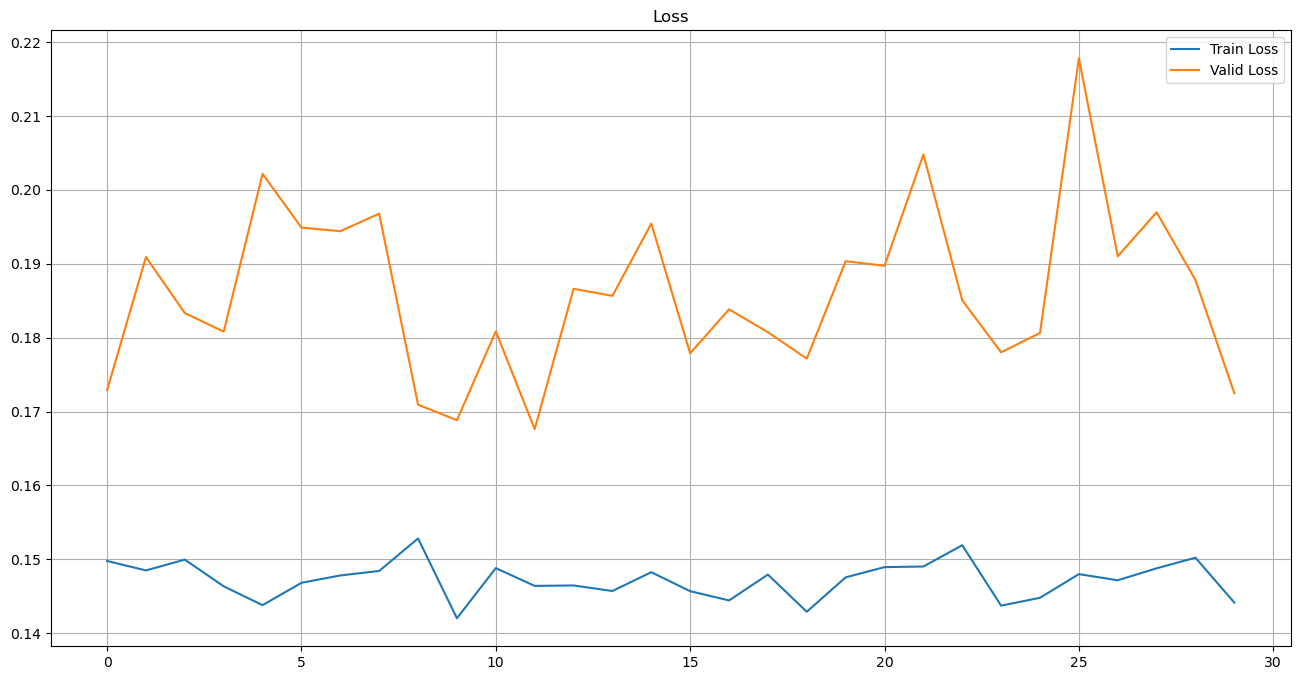

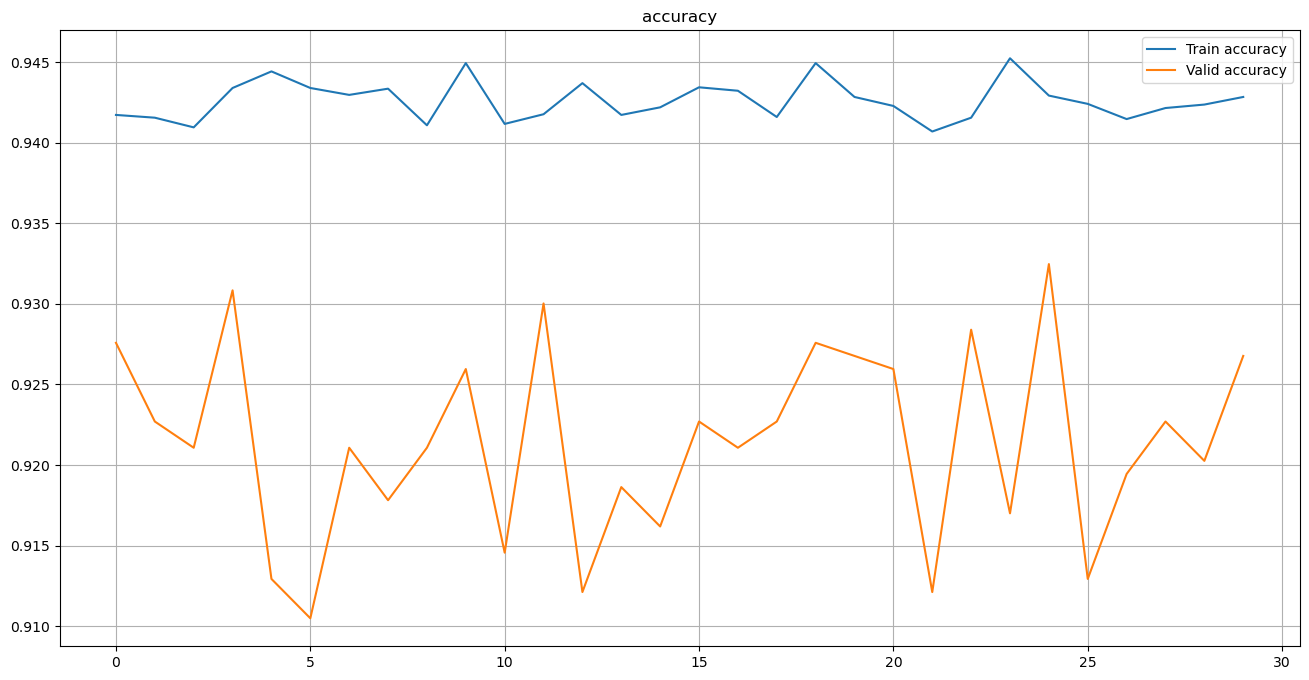

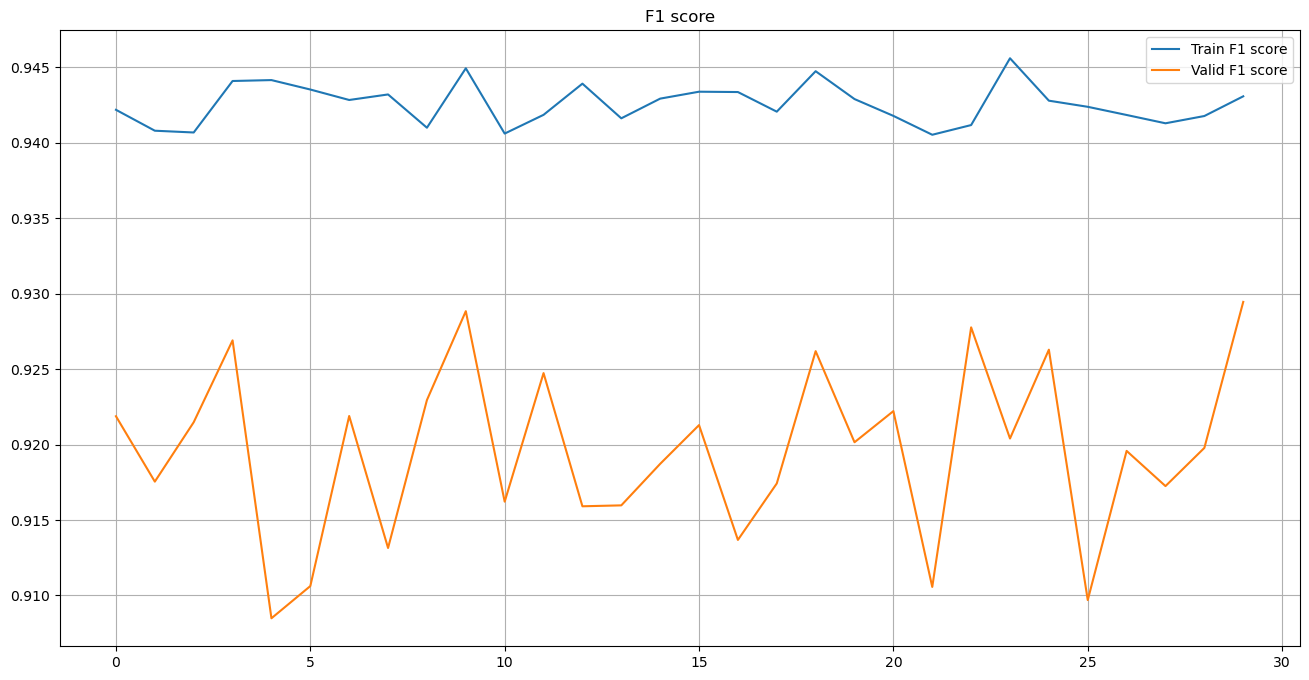

In [86]:
plot_stats(
    **history,
    title=f"Model {config.model_name}"
)

Interactive training tensorboards are available on wandb:

In [87]:
print(wandb_run.url)

https://wandb.ai/remainedmind/binary-classification-project/runs/gd9dccs2


# Result evaluation

Let's test our Model by prediction the similarity between objects that are nearest in the vector area. For that case we will use our NearestNeighbors trained algorithm.

In [171]:
@torch.inference_mode()
def get_probabilities(model, dataloader, device,):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    target_labels = []

    with tqdm(dataloader, desc="Processing",unit="batch") as process:
        for anchor_vector, pair_vector, is_same_class in process:
            anchor_vector = anchor_vector.to(device)
            pair_vector = pair_vector.to(device)
            is_same_class = is_same_class.to(device)

            predicted_similarity = model(anchor_vector, pair_vector)
            predicted_similarity = torch.squeeze(predicted_similarity, dim=-1)


            predictions.extend(predicted_similarity.cpu().numpy())
            target_labels.extend(is_same_class.cpu().numpy())

    return np.array(predictions), np.array(target_labels)

In [172]:
predicted_proba, target_labels = get_probabilities(model=perceptron_model, dataloader=test_dataloader, device=device)

Processing: 100%|██████████| 308/308 [00:02<00:00, 117.82batch/s]


In [0]:
def plot_metric_curves(y_true, y_scores):
    # Compute Precision-Recall and ROC curves
    precision, recall, thresholds  = precision_recall_curve(y_true, y_scores, drop_intermediate=False)
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Compute F1 scores for different thresholds
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

    # Find the threshold that maximizes F1 score
    best_f1_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_index]
    best_f1 = f1_scores[best_f1_index]

    # Compute area under the curves
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot Precision-Recall-F1 curve
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.scatter(
        recall[best_f1_index], precision[best_f1_index], color='red', label='Max F1 is %.2f)' % best_f1
    )
    plt.legend(loc='lower left')

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    plt.subplot(1, 3, 3)
    plt.plot(recall, f1_scores, color='darkorange', lw=2, label='F1 curve')
    # plt.plot(recall, [0, *thresholds], color='darkorange', lw=2, label='F1 curve')

    plt.xlabel('Recall')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.scatter(recall[best_f1_index], best_f1, color='red', label='Extrema  (F1 = %.2f)' % best_f1 + ' with t=%.2f' % best_threshold)
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

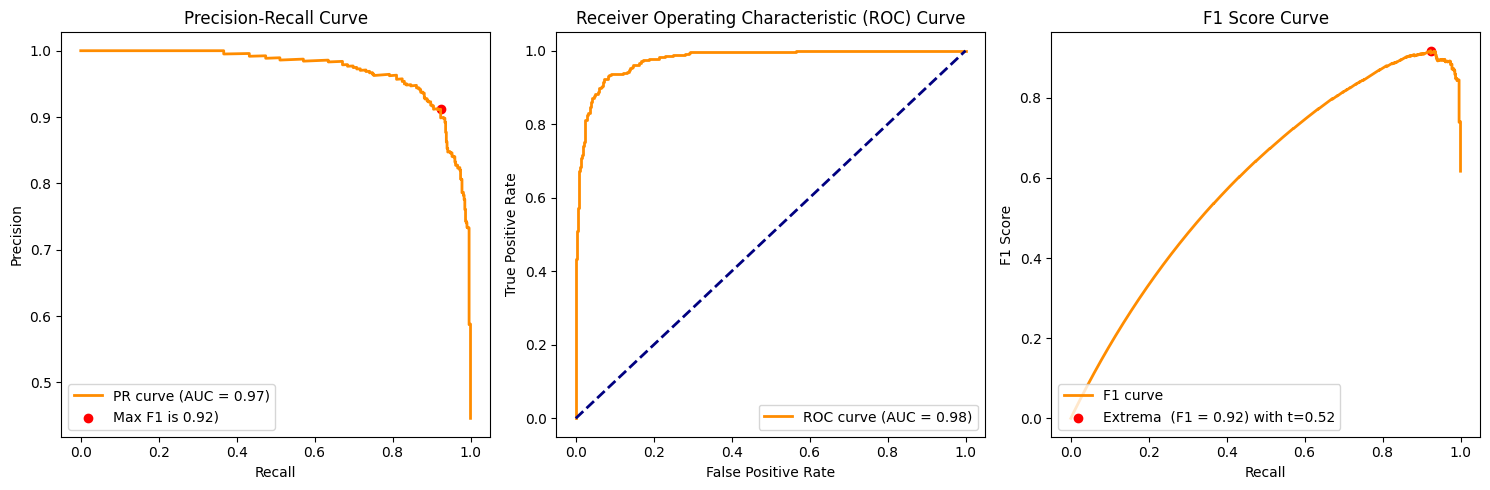

In [197]:
plot_metric_curves(target_labels, predicted_proba)